In [1]:
import glob
from os.path import join
import ntpath
import cv2
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
import os
import time
%matplotlib inline

In [2]:
def read_test_images():
    filenames = [f for f in glob.glob(join('images/Test','*.jpg'))]
    filenames = sorted(filenames)
    print("There are {} test images".format(len(filenames)))
    images = [cv2.imread(f,cv2.IMREAD_GRAYSCALE) for f in filenames]
    images = np.reshape(images, (len(images),-1))
    labels = [int(ntpath.basename(f)[:5]) for f in filenames]
    
    return np.array(images),np.array(labels)

In [3]:
def read_train_images():
    filenames = [f for f in glob.glob(join('images/Train','*.jpg'))]
    filenames = sorted(filenames)
    print("There are {} train images".format(len(filenames)))
    
    images = [cv2.imread(f,cv2.IMREAD_GRAYSCALE) for f in filenames]
    images = np.reshape(images, (len(images),-1))
    labels = [int(ntpath.basename(f)[:5]) for f in filenames]
    
    return np.array(images),np.array(labels)

In [4]:
X_train,y_train = read_train_images()
X_test,y_test = read_test_images()
mean = np.mean(X_train,axis=0)

There are 25 train images
There are 40 test images


In [5]:
unique,counts = np.unique(y_train,return_counts=True)
print('Train counts',counts)

unique,counts = np.unique(y_test,return_counts=True)
print('Test counts',counts)


Train counts [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Test counts [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [6]:
def compute_l2_distance(a,b):
    # Input:
    # a - D dimensional image as a row
    # b - D dimensional image as a row
    
    # Returns `distance` scaler value
    distance = np.sqrt(np.sum((a-b)*(a-b)))
    return distance

In [7]:
def get_threshold_and_performance_metrics(genuine_scores,imposter_scores,type2_error_weight=1):
    min_error = len(genuine_scores) + len(imposter_scores)
    min_threshold = 0
    #print(len(genuine_scores), len(imposter_scores))
    all_scores = genuine_scores + imposter_scores
    #print(len(all_scores))
    for threshold in all_scores:
        # Type1 error: rejecting genuine face - FRR
        type1 = len([s for s in genuine_scores if s >= threshold ])         
        # Type2 error: accepting imposter - FAR
        type2 = len([s for s in imposter_scores if s < threshold ])  
        num_errors = type1 + type2*type2_error_weight
        if num_errors < min_error:
            min_type1 = type1
            min_type2 = type2
            min_error = num_errors
            min_threshold = threshold
            
    FRR = min_type1/len(genuine_scores)
    FAR = min_type2/len(imposter_scores)
    print("FRR: type1 error: {}/{} ".format(min_type1,len(genuine_scores)))
    print("FAR: type2 error: {}/{} ".format(min_type2,len(imposter_scores)))
    #print("found thershold:",min_threshold)
    print('min_error: ',min_error)
    return min_threshold,FAR,FRR

In [8]:
# genuine_matching_scores
def get_genuine_scores(X_test):
    num_test = X_test.shape[0]
    # Use pairs of same person to compute the score distribution of
    #genuine matching scores.
    #tick = time.time()
    genuine_matching_scores = [compute_l2_distance(X_test[i],X_test[i+1]) for i in range(0,num_test,2)]
    #tock = time.time()
    #d = tock-tick
    #print("Genuine  Imgs/sec: {0:.2}".format(d/len(genuine_matching_scores)))
    return genuine_matching_scores

def get_imposter_scores(X_test):
    num_test = X_test.shape[0]
    #Use the first image of each person to matching with the first images
    #of others to compute the imposter matching scores
    imposter_matching_scores = []
    d = 0
    repeat_for_amortized_time = 1
    for k in range(repeat_for_amortized_time):
        imposter_matching_scores = []
        for i in range(0,num_test,2):
            for j in range(i+2,num_test,2):
                tick = time.time()
                imposter_matching_scores.append(compute_l2_distance(X_test[i],X_test[j]))
                tock = time.time()
                d += tock-tick
    print("Imposter Imgs/sec: {0:.2}".format(len(imposter_matching_scores)*repeat_for_amortized_time/d))

    return imposter_matching_scores

Imposter Imgs/sec: 1.2e+04
FRR: type1 error: 8/20 
FAR: type2 error: 0/190 
min_error:  8
for threshold of 0.87 --> Falsing Matching Rate(FMR/FAR): 0.00 / False Non-Matching Rate(FNMR/FRR): 40.00 


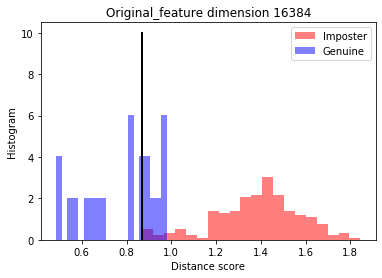

In [9]:
X_test_norm = X_test - mean
X_test_norm = normalize(X_test_norm)
genuine_matching_scores = get_genuine_scores(X_test_norm)
imposter_matching_scores = get_imposter_scores(X_test_norm)

num_bins = min(len(genuine_matching_scores),len(imposter_matching_scores))
plt.hist(imposter_matching_scores, bins=num_bins,density=True, alpha=0.5, label='Imposter', facecolor='red')
plt.hist(genuine_matching_scores, bins=num_bins, density=True, alpha=0.5, label='Genuine', facecolor='blue')

plt.legend()
plt.xlabel('Distance score')
plt.ylabel('Histogram')
plt.title('Original_feature dimension {}'.format(X_test.shape[1]))
threshold,FAR,FRR = get_threshold_and_performance_metrics(genuine_matching_scores,
                                                          imposter_matching_scores,type2_error_weight=10)
plt.plot([threshold, threshold], [0, 10], 'k-', lw=2, label='Distance Threshold')
print("for threshold of {0:.2f} --> Falsing Matching Rate(FMR/FAR): {1:.2f}\
 / False Non-Matching Rate(FNMR/FRR): {2:.2f} ".format(threshold,100*FAR,100*FRR))
plt.savefig('visualizations/thresholds/without_pca.png')
plt.show()


## PCA

In [10]:

def find_covariance_matrix(X_train):
    # returns covariance matrix C  [D x D] where D is number of features/pixels 
    num_train = X_train.shape[0]
    mean = np.mean(X_train,axis=0) # D
    B = X_train - mean # [N x D] where N is number of train images
    B = normalize(B) # I think normalizing will speed up eigenvector/eigenvalue matrix factorization
    C = 1./(num_train-1)*np.dot(B.T,B) # [D x D]
    return C

In [11]:
# saving eigenvectors in sorted fashion only once
def compute_n_save_eigens(C):
    orig_eigenvalues, orig_eigenvectors = np.linalg.eig(C)
    eigenvectors = np.real(orig_eigenvectors)
    eigenvalues = np.real(orig_eigenvalues)

    # we need descending order, remember higher eigenvalue means more important dimension
    indices = np.flip(np.argsort(eigenvalues)) 
    eigenvectors = eigenvectors[:,indices] # note, sorting column because x[:,i] columns contains i-th eigenvect
    eigenvalues = eigenvalues[indices]

    #saving matrices, because computing was a bit time consuming
    np.save('eigenvectors.npy',eigenvectors)
    np.save('eigenvalues.npy',eigenvalues)
    print("Computed,sorted and saved eigens")

In [12]:
def pca(eigenvectors,X,n_components):
    # Input:
    # X          -  [N x D]
    # eigenvectors/principal components -  [D x D] - each column represents single eigenvector, 
    #they are sorted according to importance (maximum variation in feature values)
    
    # Returns:
    # projected_X - [N x k] where K<<D    
    pc = eigenvectors[:,:n_components]
    best_components = pc # [D x K]
    projected_X = np.dot(X,best_components) # [N x K]
    return projected_X

In [13]:
#if you do not provide eigenvectors it is time consuming to compute (25min)
if not os.path.isfile('eigenvectors.npy'):
    tick = time.time()
    C = find_covariance_matrix(X_train)
    compute_n_save_eigens(C) # finds, sorts and saves eigen vecor and eigen values
    tock = time.time()
    print('EigenVectors/Values computed in {0:.0f} sec.'.format(tock-tick)) # takes about 25min  
    
# loading saved eigenvectors
eigenvectors = np.load('eigenvectors.npy')
eigenvalues = np.load('eigenvalues.npy')
mean = np.mean(X_train)
print('Loaded eigen vectors of shape ', eigenvectors.shape)


Loaded eigen vectors of shape  (16384, 16384)


In [14]:
eigenvectors[0,:10]

array([ 0.00235526,  0.00141418, -0.0031166 , -0.00588016,  0.00529884,
       -0.01650022, -0.01478567, -0.02248772, -0.01538704, -0.01015275])

In [15]:
eigenvalues[:10]

array([0.23757575, 0.128174  , 0.07879236, 0.06821604, 0.05801386,
       0.05137721, 0.04866766, 0.04232051, 0.03731889, 0.03526352])

Imposter Imgs/sec: 1.5e+05
FRR: type1 error: 7/20 
FAR: type2 error: 0/190 
min_error:  7
for threshold of 0.31 --> Falsing Matching Rate(FMR/FAR): 0.00 / False Non-Matching Rate(FNMR/FRR): 35.0 


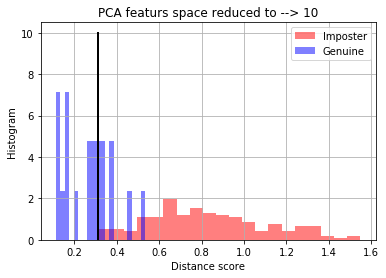

In [16]:
n_components=10

X_test_norm =X_test - mean
X_test_norm = normalize(X_test_norm)
X_test_pca = pca(eigenvectors,X_test_norm,n_components=n_components)

genuine_matching_scores = get_genuine_scores(X_test_pca)
imposter_matching_scores = get_imposter_scores(X_test_pca)

plt.clf()
plt.close()
num_bins = min(len(genuine_matching_scores),len(imposter_matching_scores))

# plot histogram of distance scores
plt.hist(imposter_matching_scores, bins=num_bins,density=True, alpha=0.5, label='Imposter', facecolor='red')
plt.hist(genuine_matching_scores, bins=num_bins, density=True, alpha=0.5, label='Genuine', facecolor='blue')
plt.legend()
plt.grid()
plt.xlabel('Distance score')
plt.ylabel('Histogram')
plt.title('PCA featurs space reduced to --> {}'.format(n_components))

#put the found threshold
threshold,FAR,FRR = get_threshold_and_performance_metrics(genuine_matching_scores,
                                                          imposter_matching_scores,type2_error_weight=10)
plt.plot([threshold, threshold], [0, 10], 'k-', lw=2, label='Distance Threshold')
print("for threshold of {0:.2f} --> Falsing Matching Rate(FMR/FAR): {1:.2f}\
 / False Non-Matching Rate(FNMR/FRR): {2:} ".format(threshold,100*FAR,100*FRR))
plt.savefig('visualizations/thresholds/pca_{}.png'.format(n_components),dpi=100)
plt.show()

In [17]:
eigenvectors[0,:10]

array([ 0.00235526,  0.00141418, -0.0031166 , -0.00588016,  0.00529884,
       -0.01650022, -0.01478567, -0.02248772, -0.01538704, -0.01015275])

## Visualizing EigenFaces 

In [18]:
def normalize_to_image_range(x,increase_whiteness=1):
    x *= 255./np.max(x)*increase_whiteness
    x = np.minimum(255,x)
    return x

### Best 100 EigenFaces 

In [19]:
num_eigenfaces_to_visualize = 100
sz = (128,128) 
# eigenvectors [D x D] where D = 128*128
for i in range(num_eigenfaces_to_visualize):
    eigenface = eigenvectors[:,i] # [D x 1]
    filename=  'visualizations/eigenfaces/{0:05}.png'.format(i)
    eigenface = eigenface.reshape(sz) #[128 x 128]
    eigenface = normalize_to_image_range(eigenface)
    cv2.imwrite(filename,eigenface)

# Covariance Matrix visualization

### For original image

In [20]:
# 
# reszie train image (128,128) -> (10,10) so that we can compare Cov matrix with PCA 100 CovMat
X_train_reshaped = X_train.reshape((-1,128,128)) # returning to original shape
sz = (10,10) # we will resize (128,128) --> (10,10)
num_features = np.product(sz) 
new_X_train = []
for i in range(X_train_reshaped.shape[0]):
    new_X_train.append(cv2.resize(X_train_reshaped[i],sz))
new_X_train = np.array(new_X_train)
new_X_train = new_X_train.reshape(new_X_train.shape[0],-1)


In [21]:
C = find_covariance_matrix(new_X_train)
C = C*C
C = normalize_to_image_range(C,increase_whiteness=num_features)
print(C.shape)
cv2.imwrite('visualizations/covariance/original-{}.png'.format(sz),C)

(100, 100)


False

### For PCA projetcted image with 100PCs

In [22]:
X_train_projected = pca(eigenvectors,X_train,n_components=num_features)
C = find_covariance_matrix(X_train_projected)
C = C*C
C = normalize_to_image_range(C,increase_whiteness=num_features)
print(C.shape)
cv2.imwrite('visualizations/covariance/{}PCs.png'.format(num_features),C)

(100, 100)


False